In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
sales = pd.read_csv('data/shop_sales.csv')

#данные о датах и праздниках (соединяется с продажами по полю date_id)
calendar = pd.read_csv('data/shop_sales_dates.csv')

#данные о датах и праздниках (соединяется с датами по полю wm_yr_wk)
prices = pd.read_csv('data/shop_sales_prices.csv')

data = sales.merge(calendar, on='date_id', how='inner')
data.item_id = data.item_id.str[6:]
prices = prices[prices.store_id == 'TX_2']
prices.item_id = '3_' + prices.item_id.str[5:]
data = data.merge(prices, on=['item_id', 'wm_yr_wk'], how='left')
data['date'] = pd.to_datetime(data['date'])
data = data[data['store_id_x'] == 'STORE_3']

In [ ]:
class MetaClass():
    def __init__(self, train_dir_path='data', inference_path='shop_sales_test.csv'):
        self.data = self.read_data(train_dir_path)
        self.inference_path = inference_path

    def data_transform(self, data, anomaly=False):
        data['event_name_1'].fillna('unknown', inplace = True)
        data['event_type_1'].fillna('unknown', inplace = True)

        encoder = preprocessing.LabelEncoder()
        data['event_name_1'] = encoder.fit_transform(data['event_name_1'])
        data['event_type_1'] = encoder.fit_transform(data['event_type_1'])

        if anomaly:
            data['cnt'] = self.anomaly_preporation(data['cnt'])

        return data


    def add_features(self, data):
        window = 28
        periods = [7, 15, 30, 90]
        group = data['cnt']

        # most recent lag data
        for period in periods:
            data[f'lag{period}'] = group.shift(period)
            data[f'qnt_rolling_mean_t{period}'] = group.transform(lambda x: x.shift(window).rolling(period).mean())
            data[f'qnt_rolling_std_t{period}'] = group.transform(lambda x: x.shift(window).rolling(period).std())

        data['date'] = pd.to_datetime(data['date'])
        time_features = ['quarter', 'day', 'dayofweek', 'dayofyear']
        dtype = np.int16
        for time_feature in time_features:
            data[time_feature] = getattr(data['date'].dt, time_feature).astype(dtype)
        data['week'] = data['date'].dt.isocalendar().week.astype(dtype)

        return data


    def inference(self):
        item_idxs = self.data.item_id.unique()
        tests = pd.read_csv(self.inference_path)
        models = self.load_model()
        preds = dict()
        for item in item_idxs:
            df = self.data[self.data.item_id == item].copy()
            test = tests[tests.item_id.str[6:] == item].copy()
            df = self.data_transform(df)
            df = self.add_features(df)

            FEATURES = self.get_columns()
            inference_df = self.create_inference_df(df)
            future_w_features = inference_df.query('isFuture').copy()

            preds[item] = models[item].predict(future_w_features[FEATURES])

        metrics = self.metrics(tests, preds)

        for per in metrics.values():
            print(per)

        return metrics


    def metrics(self, tests, preds):
        mape_func = MeanAbsolutePercentageError()
        mae_func = MeanAbsoluteError()
        item_idxs = self.data.item_id.unique()
        metrics_ = dict()
        for period in [7, 30, 90]:
            df_period = pd.DataFrame(index=item_idxs, columns=['mae', 'mape'])
            for item in item_idxs:
                y_test = np.array(tests[tests.item_id.str[6:] == item]['cnt'])[:period]
                y_pred = preds[item][:period]

                df_period.loc[item, 'mape'] = (mape_func.evaluate_by_index(y_test, y_pred)*100).mean();
                df_period.loc[item, 'mae'] = (mae_func.evaluate_by_index(y_test, y_pred)).mean();
            metrics_[period] = df_period
        return metrics_


    def create_inference_df(self, data):
        future = pd.date_range('2016-01-21', '2016-04-21', freq='D')
        future_df = pd.DataFrame({'date': future})
        future_df['isFuture'] = True
        data['isFuture'] = False
        df_and_future = pd.concat([data, future_df])
        df_and_future.reset_index(drop=True, inplace=True)
        df_and_future = self.add_holydays(df_and_future)
        df_and_future = self.data_transform(df_and_future)
        df_and_future = self.add_features(df_and_future)

        return df_and_future


    def fit(self, save_models=False):
        item_idxs = self.data.item_id.unique()
        models = dict()
        for item in item_idxs:
            df = self.data[self.data.item_id == item].copy()
            df = self.data_transform(df)
            df = self.add_features(df)
            df = df.reset_index(drop=True)
            df = df.loc[df[df.cnt > 0].index[0]:, :].reset_index(drop=True)

            tss = TimeSeriesSplit(n_splits=5, test_size=90, gap=0)
            fold = 0
            preds = []
            scores = []
            for train_idx, val_idx in tss.split(df):
                train = df.iloc[train_idx]
                test = df.iloc[val_idx]

                FEATURES = self.get_columns()
                TARGET = 'cnt'

                X_train = train[FEATURES]
                y_train = train[TARGET]
                # y_train = anomaly_preporation(y_train)

                X_test = test[FEATURES]
                y_test = test[TARGET]

                reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                                      n_estimators=1000,
                                      early_stopping_rounds=50,
                                      objective='reg:squarederror',
                                      max_depth=3,
                                      learning_rate=0.01)
                reg.fit(X_train, y_train,
                        eval_set=[(X_train, y_train), (X_test, y_test)],
                        verbose=100)

                models[f'{item}'] = reg

                y_pred = reg.predict(X_test)
                preds.append(y_pred)
                score = np.sqrt(mean_squared_error(y_test, y_pred))
                scores.append(score)

        if save_models:
            self.save_model(models)

        return reg, (y_test, y_pred)


    def save_model(self, model):
        with open('lgb_models.pkl', 'wb') as f:
            pickle.dump(model, f)


    def load_model(self):
        with open('lgb_models.pkl', 'rb') as f:
            models = pickle.load(f)
        return models


    def add_holydays(self, df):
        start, end = pd.Timestamp('2014-01-01'), pd.Timestamp('2014-01-01')
        holidays = df[(df['date'] >= start) & (df['date'] < end)][['event_name_1', 'event_type_1', 'date']]
        holidays['dd'] = holidays['date'].map(lambda x: (x.month, x.day))
        holidays.set_index('dd', inplace=True)
        event_name = holidays.event_name_1
        event_type = holidays.event_type_1

        df['event_name_1'] = df['date'].map(lambda x: event_name.get((x.month, x.day), 'unknown'))
        df['event_type_1'] = df['date'].map(lambda x: event_type.get((x.month, x.day), 'unknown'))

        return df


    def anomaly_preporation(self, demand):
        Q1 = demand.quantile(0.25)
        Q3 = demand.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = demand[(demand < lower_bound) | (demand > upper_bound)]

        demand[outliers.index] = demand.median()
        return demand


    def get_columns(self):
        columns = [
            'day', 'week', 'dayofweek', 'dayofyear', 'month', 'quarter', 'year',
            'event_name_1', 'event_type_1', 'CASHBACK_STORE_2', 'sell_price',
            'qnt_rolling_mean_t7', 'qnt_rolling_std_t7', 'qnt_rolling_mean_t15',
            'qnt_rolling_std_t15', 'qnt_rolling_mean_t30', 'qnt_rolling_std_t30',
            'qnt_rolling_mean_t90', 'qnt_rolling_std_t90',
            'lag7', 'lag15', 'lag30', 'lag90'
        ]
        return columns


    def read_data(self, data_dir_path):
        sales = pd.read_csv(f'{data_dir_path}/shop_sales.csv')
        calendar = pd.read_csv(f'{data_dir_path}/shop_sales_dates.csv')
        prices = pd.read_csv(f'{data_dir_path}/shop_sales_prices.csv')

        data = sales.merge(calendar, on='date_id', how='inner')
        data.item_id = data.item_id.str[6:]
        prices = prices[prices.store_id == 'TX_2']
        prices.item_id = '3_' + prices.item_id.str[5:]
        data = data.merge(prices, on=['item_id', 'wm_yr_wk'], how='left')
        data['date'] = pd.to_datetime(data['date'])
        data = data[data['store_id_x'] == 'STORE_3']

        return data

In [ ]:
data = data[data.item_id == '3_587']
df = data.copy()#[data.item_id == '3_586']#['cnt'].plot(kind='hist', bins=500)

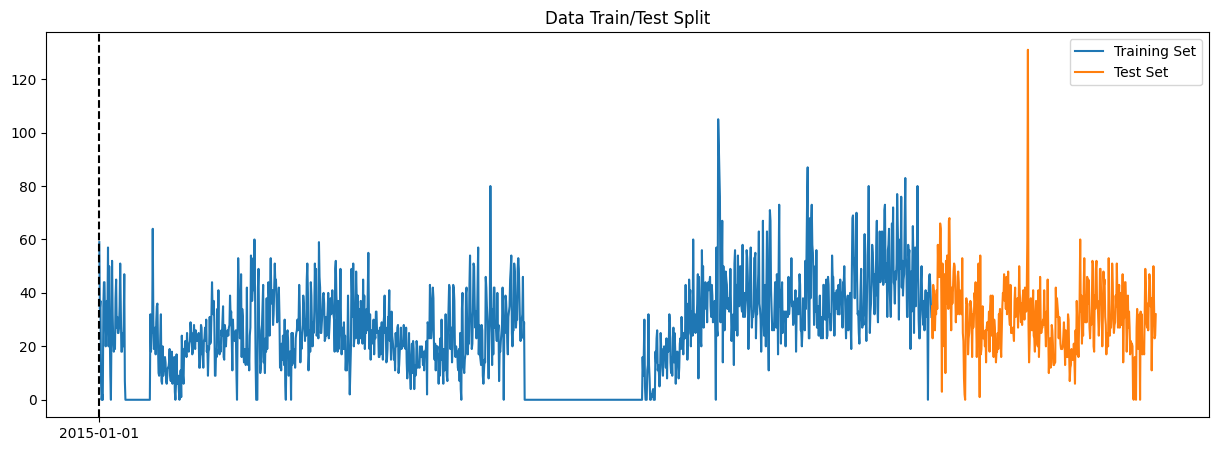

In [ ]:
train = df.loc[df['date'] < '2015-01-01']
test = df.loc[df['date'] >= '2015-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train['cnt'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['cnt'].plot(ax=ax, label='Test Set')
ax.axvline('2015-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=90, gap=0)
df = df.sort_index()

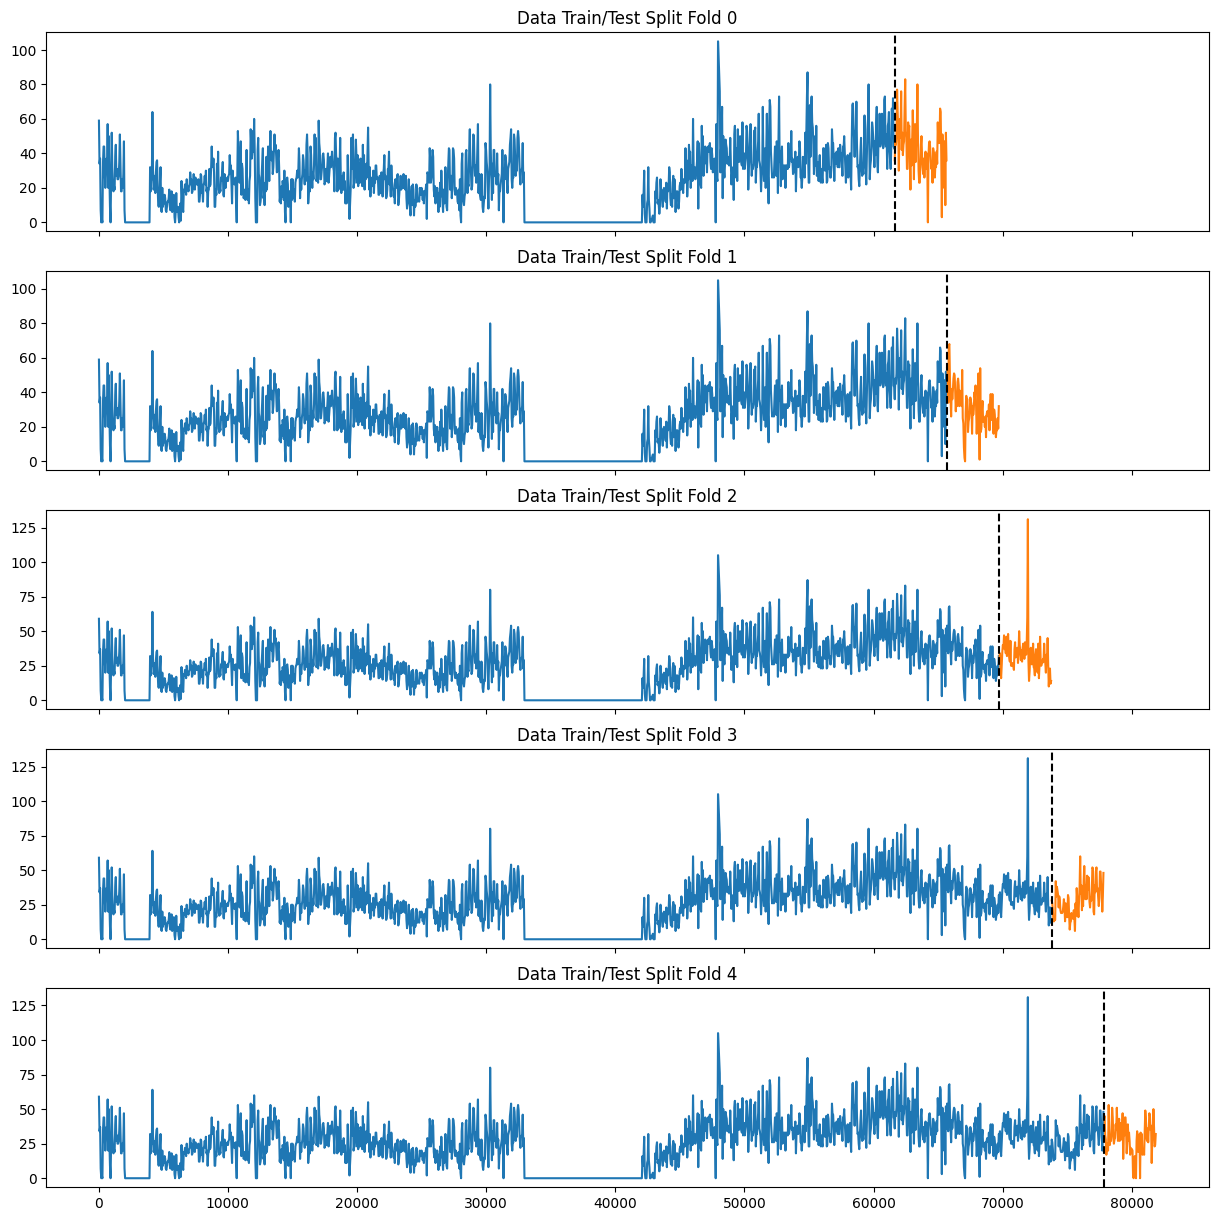

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['cnt'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['cnt'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
from sklearn import preprocessing

def transform(data):

    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)

    cat = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])

    return data

In [ ]:
def anomaly_preporation(demand):
    Q1 = demand.quantile(0.25)
    Q3 = demand.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = demand[(demand < lower_bound) | (demand > upper_bound)]

    demand[outliers.index] = demand.median()
    return demand

In [ ]:
def add_features(data, clear=False):

    window = 28
    periods = [7, 15, 30, 90]
    group = anomaly_preporation(data['cnt']) if clear else data['cnt']

    # most recent lag data
    for period in periods:
        data[f'lag{period}'] = group.shift(period)
        data[f'qnt_rolling_mean_t{period}'] = group.transform(lambda x: x.shift(window).rolling(period).mean())
        data[f'qnt_rolling_std_t{period}'] = group.transform(lambda x: x.shift(window).rolling(period).std())

    data['date'] = pd.to_datetime(data['date'])
    time_features = ['quarter', 'week', 'day', 'dayofweek', 'dayofyear']
    dtype = np.int16
    for time_feature in time_features:
        data[time_feature] = getattr(data['date'].dt, time_feature).astype(dtype)

    return data


df = add_features(df)

<ipython-input-475-20a3f5f4a882>:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data[time_feature] = getattr(data['date'].dt, time_feature).astype(dtype)


In [ ]:
columns = ['day', 'week', 'dayofweek', 'dayofyear', 'month', 'quarter', 'year', 'event_name_1', 'event_type_1',
           'CASHBACK_STORE_2', 'sell_price', 'qnt_rolling_mean_t7',
           'qnt_rolling_std_t7', 'qnt_rolling_mean_t15', 'qnt_rolling_std_t15',
           'qnt_rolling_mean_t30', 'qnt_rolling_std_t30', 'qnt_rolling_mean_t90',
           'qnt_rolling_std_t90', 'lag7', 'lag15', 'lag30', 'lag90'
]

In [ ]:
def for_item(date):
    if date >= pd.Timestamp('2012-04-01') and date < pd.Timestamp('2012-09-01'):
      return 0
    elif date >= pd.Timestamp('2014-05-01') and date < pd.Timestamp('2014-09-01'):
      return 0
    elif date >= pd.Timestamp('2016-05-01') and date < pd.Timestamp('2016-09-01'):
      return 0
    else:
      return 1

In [ ]:
df.date = pd.to_datetime(df.date)
df['for_3_065'] = df.date.apply(for_item)

In [ ]:
fold = 0
preds = []
scores = []

tss = TimeSeriesSplit(n_splits=5, test_size=90)

for item in data.item_id.unique():
    df = df[df['item_id'] == item]
    df = transform(df)
    df = add_features(df)
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        FEATURES = columns
        TARGET = 'cnt'

        X_train = train[FEATURES]
        y_train = train[TARGET]
        # y_train = anomaly_preporation(y_train)

        X_test = test[FEATURES]
        y_test = test[TARGET]

        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                              n_estimators=1000,
                              early_stopping_rounds=50,
                              objective='reg:linear',
                              max_depth=3,
                              learning_rate=0.01)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)


        print(metrics_report(y_true, y_pred))

[17:44:47] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:28.72547	validation_1-rmse:44.61624


<ipython-input-475-20a3f5f4a882>:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data[time_feature] = getattr(data['date'].dt, time_feature).astype(dtype)


[100]	validation_0-rmse:14.61858	validation_1-rmse:22.94838
[200]	validation_0-rmse:10.80260	validation_1-rmse:16.45202
[300]	validation_0-rmse:9.65475	validation_1-rmse:14.98826
[400]	validation_0-rmse:9.13773	validation_1-rmse:14.56607
[500]	validation_0-rmse:8.81727	validation_1-rmse:14.55118
[504]	validation_0-rmse:8.80563	validation_1-rmse:14.55411
[17:44:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29.94618	validation_1-rmse:33.03814
[100]	validation_0-rmse:15.10304	validation_1-rmse:14.81084
[200]	validation_0-rmse:11.13098	validation_1-rmse:11.74953
[300]	validation_0-rmse:9.96074	validation_1-rmse:11.53227
[334]	validation_0-rmse:9.76080	validation_1-rmse:11.53680
[17:44:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:30.13633	validation_1-rmse:34.60240
[100]	validation_0-rmse:15.20386	validation_1-rmse:1

In [ ]:
def add_holydays(df):
    holidays = df[(df['date'] >= '2014-01-01') & (df['date'] < '2015-01-01')][['event_name_1', 'event_type_1', 'date']]
    holidays['dd'] = holidays['date'].map(lambda x: (x.month, x.day))
    holidays.set_index('dd', inplace=True)
    event_name = holidays.event_name_1
    event_type = holidays.event_type_1

    df['event_name_1'] = df['date'].map(lambda x: event_name.get((x.month, x.day), 'unknown'))
    df['event_type_1'] = df['date'].map(lambda x: event_type.get((x.month, x.day), 'unknown'))

    return df

In [ ]:
future = pd.date_range('2013-01-30', '2013-08-21', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
future_df['date'] = future
data['isFuture'] = False
df_and_future = pd.concat([data, future_df])
df_and_future.reset_index(drop=True, inplace=True)
df_and_future = add_holydays(df_and_future)
df_and_future = transform(df_and_future)
df_and_future = add_features(df_and_future)

<ipython-input-325-bb8e423b0ae4>:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data[time_feature] = getattr(data['date'].dt, time_feature).astype(dtype)


In [ ]:
future_w_features = df_and_future.query('isFuture').copy()
preds = reg.predict(future_w_features[FEATURES])

In [ ]:
pd.Series(preds).shape, df[df.item_id == '3_587'].reset_index(drop=True)[['cnt', 'date']][732:936].shape

((203,), (204, 2))

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError,MeanAbsolutePercentageError
from sklearn.metrics import r2_score

mape_func = MeanAbsolutePercentageError()
mapes = mape_func.evaluate_by_index(y_test,y_pred)*100

/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:466: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
